In [1]:
import serial, random, matplotlib.pyplot as plt
from time import time_ns
from scipy.sparse import lil_matrix
import numpy as np
np.set_printoptions(precision=3)
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})

In [ ]:
ser = serial.Serial('COM4', 9600, timeout = 0.1)

### Helper functions

Bitwise operations used in the Hamiltonian generation.

In [3]:
def flip(x, i, j):
    return x ^ ((1 << i) | (1 << j))

def get_spin(x, i):
    return (x >> i) & 1

def shift(x, N, k = 1): # k = number of steps to shift by
    return ((x << k) | (x >> (N - k))) & ((1 << N) - 1)

def findstate(basis, state):
    # can be implemented explicitely using binary search for example
    return basis.index(state) if state in basis else -1

def sum_bits(x):
    return bin(x).count('1')

### Non FPGA functions

In [4]:
def checkstate_k(s, N, k):
    t = s

    for i in range(1, N+1):
        t = shift(t, N)
        if t < s: return -1 # if a smaller state is found, s is not the representative, return -1
        elif t == s: # after i shifts, back to original state
            if k % (N // i) != 0:  return -1 # momentum k INcompatible with periodicity i (R = i the periodicity)
            else: return i # R = i, compatible with periodicity i
    
    return -1 # periodicity not compatible with k

def representative_k(s, N, k):
    # find the representative of the state s, which is the smallest state that can be obtained by translating
    r = s
    t = s
    l = 0
    for i in range(1, N+1):
        t = shift(t, N)
        if t < r: 
            r = t
            l = i
    
    return r, l # representative, number of translations

### FPGA functions
Remember that the FPGA must be reprogrammed for each different N.

In [20]:
def fpga(ser, N, x):
    # send state x and receive answer on uart to fpga
    
    # prepare message
    msg = x.to_bytes((N + 7) // 8, byteorder='big') # convert to bytes

    # send message
    ser.reset_input_buffer()  # Clear the input buffer
    ser.reset_output_buffer()  # Clear the output buffer
    ser.write(msg)

    # receive data
    l = int.from_bytes(ser.read(1), byteorder='big') # read(1) to read only one byte, this is all the fpga transmits
    r = shift(x, N, l)
    # print(bin(x), bin(r), l)

    return r, l

def checkstate_k_fpga(ser, x, N, k):
    r, l = fpga(ser, N, x)

    if r != x: # means that not representative
        return -1
    else:
        # if r = x it means that the state is a valid representative, 
        # and in this case the number of steps to reach it is simply the periodicity
        
        if k % (N // l) != 0:  return -1 # period not compatible with k
        else: return l

def representative_k_fpga(ser, x, N, k):
    r, l = fpga(ser, N, x)
    
    # here if r = x and x is the rep, then we get the periodicty and not l = 0
    # this allows the fpga output to also be interpreted for checkstate (see comment there)
    
    if r == x: l = 0 
    
    return r, l

### Testing FPGA functions (comparing with non FPGA)
This can take some time, consider approx. 1 second per state for the FPGA computation

In [ ]:
N = 8
k = 0

x = random.randint(0, (1 << N) - 1)

start = time_ns()
r, l = representative_k(x, N, k)
R = checkstate_k(x, N, k)
end = time_ns()

start_fpga = time_ns()
r_fpga, l_fpga = representative_k_fpga(ser, x, N, k)
R_fpga = checkstate_k_fpga(ser, x, N, k)
end_fpga = time_ns()

print(bin(x), bin(r), bin(r_fpga), l, l_fpga, R, R_fpga, (end - start) * 1e-9, (end_fpga - start_fpga) * 1e-9)

assert r == r_fpga, f"Mismatch in representative: x={bin(x)}, cpu={bin(r)}, fpga={bin(r_fpga)}"
assert l == l_fpga, f"Mismatch in number of translations: x={bin(x)}, cpu={l}, fpga={l_fpga}"
assert R == R_fpga, f"Mismatch in state check: x={bin(x)}, cpu={R}, fpga={R_fpga}"

0b111111111101011000000011 0b11111111111101011 0b101011000000011111111111 15 9 -1 -1 0.00035640000000000004 0.028527300000000002


AssertionError: Mismatch in representative: x=0b111111111101011000000011, cpu=0b11111111111101011, fpga=0b101011000000011111111111

### Generation of Hamiltonian

In [60]:
def build_basis_mz_k(N, mz, k):
    # NOTE: this is not the actual basis but rather the list of the representatives of the basis states, 
    # which is all we need to build the Hamiltonian !

    nup = N // 2 + mz
    basis_mz = [x for x in range(1 << N) if sum_bits(x) == nup] # only states with given magnetization
    basis, R_list = [], [] # R is the periodicity of the states

    for x in basis_mz:
        R = checkstate_k(x, N, k)
        if R >= 0:
            basis.append(x)
            R_list.append(R)
    
    return basis, R_list

def hamiltonian_mz_k(N, mz, k):
    basis, R_list = build_basis_mz_k(N, mz, k)
    M = len(basis) # M ≠ 2 ** N
    H = np.zeros((M, M), dtype=complex) # this is complex not !!!

    for state_idx in range(M): # looping over all states
        state = basis[state_idx]
        
        for i in range(N): # looping over all spins to flip two adjacent spins
            j = (i + 1) % N
            
            if get_spin(state, i) == get_spin(state, j):
                H[state_idx][state_idx] += 0.25
            else:
                H[state_idx][state_idx] -= 0.25
                state_flip = flip(state, i, j) 
                state_flip_rep, l = representative_k(state_flip, N, k)
                state_flip_rep_idx = findstate(basis, state_flip_rep)

                if state_flip_rep_idx >= 0:
                    h = 0.5 * (R_list[state_idx] / R_list[state_flip_rep_idx]) ** (1/2) * np.exp(1j * k * l * 2 * np.pi / N)
                    H[state_idx][state_flip_rep_idx] += h

    return H

In [ ]:
N = 8
mz = 0 # magnetisation
k = 0 # - N / 2 + 1 <= k <= N / 2

print("N:", N, "mz:", mz, "k:", k)

basis, periodicities = build_basis_mz_k(N, mz, k)
print("Basis:", basis)
print("Basis in bin:", basis, N)
print("Periodicities:", periodicities)
print("Basis size:", len(basis))

H = hamiltonian_mz_k(N, mz, k)
print("Hamiltonian:")
# for row in H:
    # print(row)

eigenvalues, eigenvectors = np.linalg.eig(H)
print("Eigenvalues:", np.real(np.round(np.sort(eigenvalues), 4))) # even if matrix is complex it is hermitian so the eigenvalues are real

N: 6 mz: 0 k: 0
Basis: [7, 11, 13, 21]
Basis in bin: [7, 11, 13, 21] 6
Periodicities: [6, 6, 6, 2]
Basis size: 4
Hamiltonian:
Eigenvalues: [-2.118 -1.5    0.118  1.5  ]


### Generation of Hamiltonian with FPGA

In [80]:
def build_basis_mz_k_fpga(ser, N, mz, k):
    # NOTE: this is not the actual basis but rather the list of the representatives of the basis states, 
    # which is all we need to build the Hamiltonian !

    nup = N // 2 + mz
    basis_mz = [x for x in range(1 << N) if sum_bits(x) == nup] # only states with given magnetization
    basis, R_list = [], [] # R is the periodicity of the states

    for x in basis_mz:
        R = checkstate_k_fpga(ser, x, N, k)
        if R >= 0:
            basis.append(x)
            R_list.append(R)
    
    return basis, R_list

def hamiltonian_mz_k_fpga(ser, N, mz, k):
    basis, R_list = build_basis_mz_k(N, mz, k)
    M = len(basis) # M ≠ 2 ** N
    # H = np.zeros((M, M), dtype=complex) # this is complex not !!!
    H = lil_matrix((M, M), dtype=complex)

    for state_idx in range(M): # looping over all states
        state = basis[state_idx]
        
        for i in range(N): # looping over all spins to flip two adjacent spins
            j = (i + 1) % N
            
            if get_spin(state, i) == get_spin(state, j):
                H[state_idx, state_idx] += 0.25
            else:
                H[state_idx, state_idx] -= 0.25
                state_flip = flip(state, i, j) 
                state_flip_rep, l = representative_k_fpga(ser, state_flip, N, k)
                state_flip_rep_idx = findstate(basis, state_flip_rep)

                if state_flip_rep_idx >= 0:
                    h = 0.5 * (R_list[state_idx] / R_list[state_flip_rep_idx]) ** (1/2) * np.exp(1j * k * l * 2 * np.pi / N)
                    H[state_idx, state_flip_rep_idx] += h

    return H

In [81]:
N = 8
mz = 0 # magnetisation
k = 0 # - N / 2 + 1 <= k <= N / 2

print("N:", N, "mz:", mz, "k:", k)

basis, periodicities = build_basis_mz_k_fpga(ser, N, mz, k)
print("Basis:", basis)
print("Basis in bin:", basis, N)
print("Periodicities:", periodicities)
print("Basis size:", len(basis))

H = hamiltonian_mz_k_fpga(ser, N, mz, k)
print("Hamiltonian:")
# for row in H:
    # print(row)

eigenvalues, eigenvectors = np.linalg.eig(H)
print("Eigenvalues:", np.real(np.round(np.sort(eigenvalues), 4))) # even if matrix is complex it is hermitian so the eigenvalues are real

N: 8 mz: 0 k: 0


ZeroDivisionError: integer division or modulo by zero

### Comparing time performances of Hamiltonian generation

Times (ns): [582000, 1637700, 6679700, 17097000, 43318900, 181582700, 1321350900]


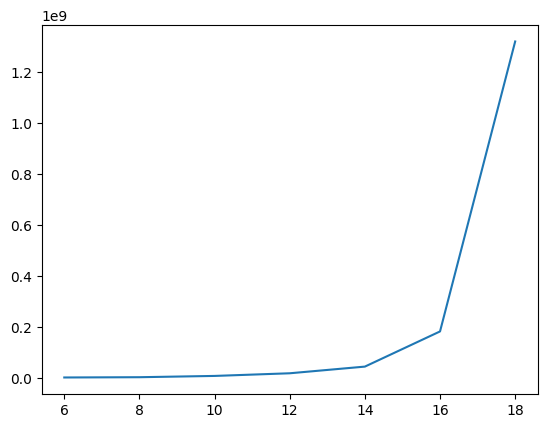

In [67]:
mz, k = 0, 0
Ns = [6, 8, 10, 12, 14, 16, 18]
times = []

for N in Ns:
    start = time_ns()
    hamiltonian_mz_k(N, mz, k)
    end = time_ns()
    times.append(end - start)

print("Times (ns):", times)
plt.plot(Ns, times)

In [ ]:
Ns_fpga = [8, 16, 24]
times_fpga = []

In [ ]:
N = Ns_fpga[0]

start = time_ns()
hamiltonian_mz_k_fpga(ser, N, mz, k)
end = time_ns()
times_fpga.append(end - start)

print("Times (ns):", times_fpga)

Times (ns): [759029000]


In [77]:
N = Ns_fpga[1]

start = time_ns()
hamiltonian_mz_k_fpga(ser, N, mz, k)
end = time_ns()
times_fpga.append(end - start)

print("Times (ns):", times_fpga)

Times (ns): [759029000, 110785486700]


In [82]:
N = 24

start = time_ns()
hamiltonian_mz_k_fpga(ser, N, mz, k)
end = time_ns()
times_fpga.append(end  - start)

print("Times (ns):", times_fpga)

KeyboardInterrupt: 

In [58]:
ser.close()  # Close the serial port when done